## Introduction
Finally we are going to train our atrium segmentation network

## Imports:

* pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* Our dataset and model



In [1]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset
from model import UNet

## Dataset Creation
Here we create the train and validation dataset. <br />
Additionally, we define our data augmentation pipeline.
Subsequently the two dataloaders are created

In [2]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])
#aug_params

In [3]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [4]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Custom Loss
Often segmentation models perform better when using a Dice Loss instead of Cross-Entropy.<br />
The Dice Loss is defined as:
$$ L(\hat{y}, y) = 1-\frac{2 |\hat{y} \cap y|}{|\hat{y}| + |y|}$$

The intersection can be easily computed by $\hat{y}$ * $y$ as both variables are binary masks.

You can read more about the Dice Score here:
https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [5]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask): #ground mask 
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred) #eg: 8b*1C*256h*256w
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


## Full Segmentation Model

We will now combine everything into the full pytorch lightning model

In [6]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)#tensorboard
        
    def configure_optimizers(self):
        return [self.optimizer] #packed in list 

In [7]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [8]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min') #save 10 to that has min dice loss

In [10]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=75)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs\lightning_logs

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluation:
Let's evaluate the model

* nibabel to load a full scan
* tqdm for progress bar when validating the model
* celluloid for easy video generation


In [12]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera


First we load a checkpoint:

In [40]:
model = AtriumSegmentation.load_from_checkpoint("weights/50.ckpt")

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint D:\Udemy-Medical PyTorch\06-Atrium-Segmentation\06-Atrium-Segmentation\weights\50.ckpt`


In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

Evalute the complete validation dataset

In [42]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)#channel dim added
    with torch.no_grad(): #no grad as it is val
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

Compute overall Dice Score (1- DiceLoss):
Wow! What a great score

In [43]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.9510)

In [44]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9509609341621399


## Visualization

We can now load a test subject from the dataset and estimate the position of the left atrium

In [45]:
subject = Path("Task02_Heart/imagesTs/la_001.nii.gz")
subject_mri = nib.load(subject).get_fdata()

As this scan is neither normalized nor standardized we need to perform those tasks!<br />
Let us copy the normalization and standardization functions from our preprocessing notebook:

In [46]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


We preprocess the scan and crop 32 px from top, bottom, back and front

In [47]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [48]:
standardized_scan.shape

(336, 336, 180)

In [49]:
preds = []
for i in range(standardized_scan.shape[-1]): #saggital
    slice = standardized_scan[:,:,i] #current slice
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0] 
        #channel dim and batch dim aftr copying again remove batch and channel dim
        pred = pred > 0.5
    preds.append(pred.cpu())

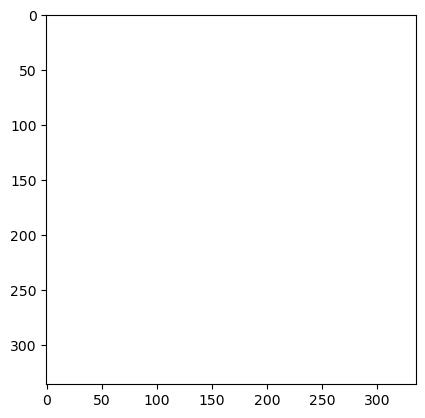

In [50]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):#saggital
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [55]:
from IPython.display import HTML
HTML(animation.to_jshtml())  # convert the animation to a video


AttributeError: module 'matplotlib.animation' has no attribute 'to_jshtml'

In [52]:
!br install ffmpeg


'apt' is not recognized as an internal or external command,
operable program or batch file.


Congratulations! You made it to the end of the segmentation lecture